<a href="https://colab.research.google.com/github/phmorris610/cs39aa_project/blob/main/project_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pyLDAvis
# !pip install textstat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import sklearn
# import gensim
# import pyLDAvis
# import wordcloud
# import textblob
# import spacy
# import textstat

In [2]:
from google.colab import files
uploaded = files.upload()

data = pd.read_csv('rtom2.csv')

tomatoes = data.dropna()
tomatoes.reset_index(inplace=True)
print(tomatoes.shape)
print(tomatoes.head())




Saving rtom2.csv to rtom2.csv
(9508, 9)
   index rotten_tomatoes_link  top_critic  T_C           publisher_name  \
0      0            m/0814255       False    0           Urban Cinefile   
1      1            m/0814255       False    0      FILMINK (Australia)   
2      2            m/0814255       False    0  Sunday Mail (Australia)   
3      3            m/0814255        True    1       Hollywood Reporter   
4      4            m/0814255        True    1         Associated Press   

  review_type  Review_Type review_date  \
0       Fresh            1    2/6/2010   
1       Fresh            1    2/9/2010   
2       Fresh            1    2/9/2010   
3      Rotten            0   2/10/2010   
4      Rotten            0   2/10/2010   

                                      review_content  
0  Uma Thurman as Medusa, the gorgon with a coiff...  
1  With a top-notch cast and dazzling special eff...  
2  Whether audiences will get behind The Lightnin...  
3  What's really lacking in The Ligh

In [4]:
selections1 = ['Review_Type', 'review_content']
selections2 = ['T_C', 'review_content']
X = tomatoes[selections1].copy()
X2 = tomatoes[selections2].copy()
y = tomatoes.pop('Review_Type')
y2 = tomatoes.pop('T_C')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

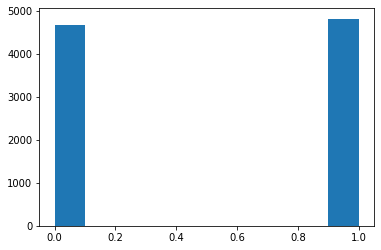

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y)
plt

In [ ]:
import numpy as np
y_num = np.asarray(y)
unique, counts = np.unique(y_num, return_counts=True)
print(f"Count of 0 = Rotten and 1 = Fresh: {dict(zip(unique, counts))}") 

Count of 0 = Rotten and 1 = Fresh: {0: 4684, 1: 4824}


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

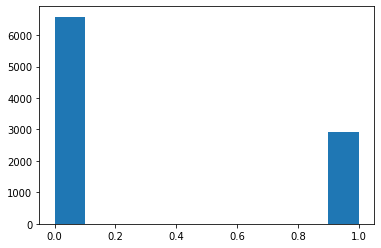

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y2)
plt

In [ ]:
import numpy as np
y_num = np.asarray(y2)
unique, counts = np.unique(y_num, return_counts=True)
print(f"Count of 0 = Not Top Critic and 1 = Top Critic: {dict(zip(unique, counts))}") 

Count of 0 = Not Top Critic and 1 = Top Critic: {0: 6587, 1: 2921}


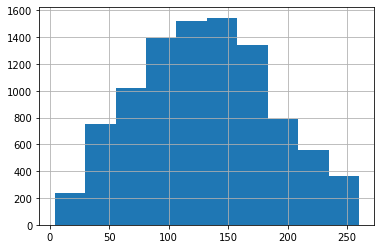

In [ ]:
X['review_content'].str.len().hist()

This shows the average length of a review is ~130 characters

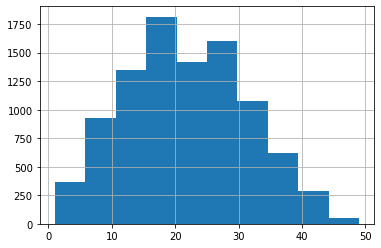

In [ ]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()
plot_word_number_histogram(X['review_content'])

This shows the average number of words per review to be ~20

#Below we will tokenize and remove characters and stopwords.

In [5]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = set(stopwords.words('english'))
corpus = []
new = X['review_content'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from collections import defaultdict

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

In [7]:
from nltk.tokenize import TreebankWordTokenizer

twt = TreebankWordTokenizer()
X['tokens_raw'] = X['review_content'].apply(lambda x: twt.tokenize(x.lower()))
chars2remove = set(
    ['.', '!', '/', '?', ',', '@', '#', '$', '%', '^', '&', '*', '_', '-', '~', 'The', 'A', '`', '+', "'", '"', '--',
     '[', ']',
     "'s", "n't"])
X['tokens_raw'] = X['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove and w not in stop])
pd.set_option("display.max_colwidth", 300)
X_tRaw = X['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove and w not in stop])
Xtclean = X_tRaw.apply(lambda x: ' '.join(x))
Xtclean.head()

0                                          uma thurman medusa gorgon coiffure writhing snakes stone-inducing hypnotic gaze one highlights bewitching fantasy
1                                                                            top-notch cast dazzling special effects tide teens next harry potter instalment
2    whether audiences get behind lightning thief hard predict. overall entertaining introduction promising new world consuming shadow potter big break free
3                                                                     really lacking lightning thief genuine sense wonder thing brings viewers back hogwarts
4                                                                                                     list ingredients movie-magic potion enjoy start finish
Name: tokens_raw, dtype: object

Let's See if Stemming makes a difference, below.

In [16]:
from nltk.stem import PorterStemmer
py_stem = PorterStemmer()
X['tokens_raw'] = X['review_content'].apply(lambda x: py_stem.stem(x.lower()))
chars2remove = set(
    ['.', '!', '/', '?', ',', '@', '#', '$', '%', '^', '&', '*', '_', '-', '~', 'The', 'A', '`', '+', "'", '"', '--',
     '[', ']',
     "'s", "n't"])
X['tokens_raw'] = X['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove and w not in stop])
pd.set_option("display.max_colwidth", 300)
X_tRaw_stem = X['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove and w not in stop])
Xtclean_stem = X_tRaw.apply(lambda x: ' '.join(x))
Xtclean_stem.head()

0                                          uma thurman medusa gorgon coiffure writhing snakes stone-inducing hypnotic gaze one highlights bewitching fantasy
1                                                                            top-notch cast dazzling special effects tide teens next harry potter instalment
2    whether audiences get behind lightning thief hard predict. overall entertaining introduction promising new world consuming shadow potter big break free
3                                                                     really lacking lightning thief genuine sense wonder thing brings viewers back hogwarts
4                                                                                                     list ingredients movie-magic potion enjoy start finish
Name: tokens_raw, dtype: object

In [ ]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    chars2remove = set(
    ['.', '!', '/', '?', ',', '@', '#', '$', '%', '^', '&', '*', '_', '-', '~', 'The', 'A', '`', '+', "'", '"', '--',
     '[', ']',
     "'s", "n't"])
    #X_train['tokens_raw'] = X_train['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:80]:
        if (word not in stop and word != 'The' and word != 'A' and word != chars2remove):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

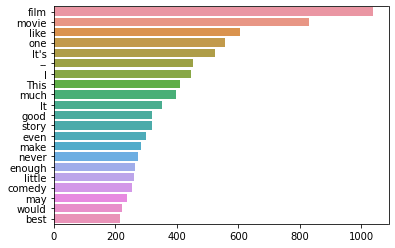

In [ ]:
plot_top_non_stopwords_barchart(X['review_content'])

Here is a list of the most popular non-stopwords, film and movie the heavy hitters.

In [ ]:
X.head()

,Review_Type,review_content,tokens_raw
0,1,"Uma Thurman as Medusa, the gorgon with a coiffure of writhing snakes and stone-inducing hypnotic gaze is one of the highlights of this bewitching fantasy","[uma, thurman, medusa, gorgon, coiffure, writhing, snakes, stone-inducing, hypnotic, gaze, one, highlights, bewitching, fantasy]"
1,1,"With a top-notch cast and dazzling special effects, this will tide the teens over until the next Harry Potter instalment.","[top-notch, cast, dazzling, special, effects, tide, teens, next, harry, potter, instalment]"
2,1,"Whether audiences will get behind The Lightning Thief is hard to predict. Overall, it's an entertaining introduction to a promising new world -- but will the consuming shadow of Potter be too big to break free of?","[whether, audiences, get, behind, lightning, thief, hard, predict., overall, entertaining, introduction, promising, new, world, consuming, shadow, potter, big, break, free]"
3,0,"What's really lacking in The Lightning Thief is a genuine sense of wonder, the same thing that brings viewers back to Hogwarts over and over again.","[really, lacking, lightning, thief, genuine, sense, wonder, thing, brings, viewers, back, hogwarts]"
4,0,It's more a list of ingredients than a movie-magic potion to enjoy from start to finish.,"[list, ingredients, movie-magic, potion, enjoy, start, finish]"


In [ ]:
XFresh = X[  X['Review_Type'] == 1 ]
Xrottn = X[  X['Review_Type'] == 0 ]
XTop   = X2[  X2['T_C'] == 1 ]
XNTop  = X2[  X2['T_C'] == 0 ]

Now lets split the data into Fresh and Rotten reviews, and also take a look at the Top Critic or not Top Critic column's bywords.

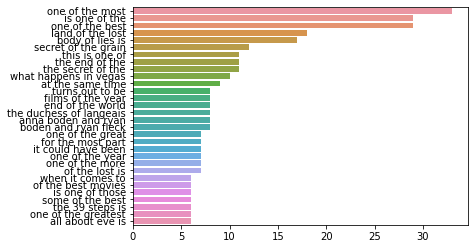

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:30]

    top_n_bigrams=_get_top_ngram(text,n)[:30]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(XFresh['review_content'],4)

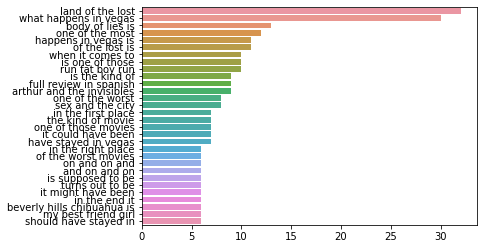

In [ ]:
plot_top_ngrams_barchart(Xrottn['review_content'],4)

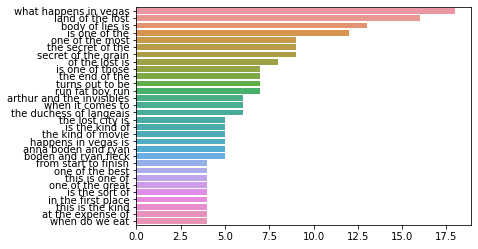

In [ ]:
plot_top_ngrams_barchart(XTop['review_content'],4)

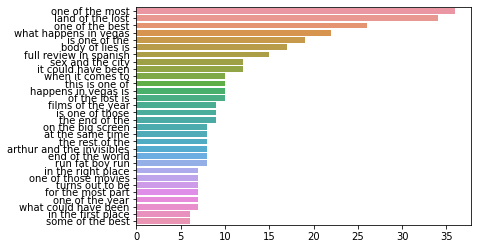

In [ ]:
plot_top_ngrams_barchart(XNTop['review_content'],4)

The results are very odd, "body of lies", "land of the lost", this leads me to believe that this dataset is very biased towards a certian few movies, this will need to be investivated further. 

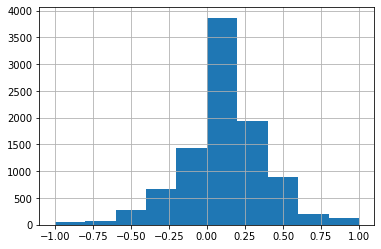

In [ ]:
from textblob import TextBlob
    
def plot_polarity_histogram(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score =text.apply(lambda x : _polarity(x))
    polarity_score.hist()

plot_polarity_histogram(X['review_content'])

As can be seen from the above polarity plot, these reviews are slightly polarizing.

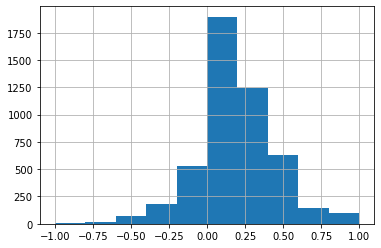

In [ ]:
plot_polarity_histogram(XFresh['review_content'])

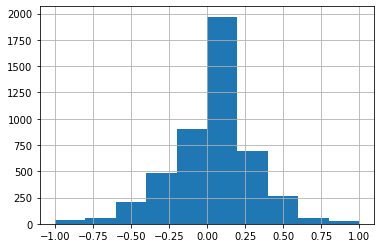

In [ ]:
plot_polarity_histogram(Xrottn['review_content'])

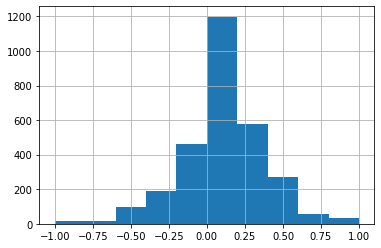

In [ ]:
plot_polarity_histogram(XTop['review_content'])

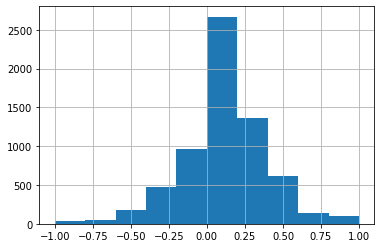

In [ ]:
plot_polarity_histogram(XNTop['review_content'])

Interestingly enough the Fresh reviews are showing as more polarizing than the Rotten reviews, while Top Critic or its complement are not registering a difference.

Now lets split the data, vectorize, then create a onehot encoding and put it through a quick and dirty model; lets use a Random Forest.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Xtclean_stem, y, train_size=0.80, random_state=1)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
Xtrain_hot = tfidf_vect.fit_transform(X_train).toarray()
Xval_hot = tfidf_vect.transform(X_val).toarray()
print(Xtrain_hot.shape)
print(Xval_hot.shape)

(7606, 16569)
(1902, 16569)


In [21]:
import torch
Xtrain_tense = torch.tensor(Xtrain_hot).float()
Xval_tense = torch.tensor(Xval_hot).float()
print(Xtrain_tense.shape)
print(X_train.shape)
print(Xval_tense.shape)
print(X_val.shape)

torch.Size([7606, 16569])
(7606,)
torch.Size([1902, 16569])
(1902,)


Now I will run it through the Random Forest portion of a Classification Class.

In [22]:
class Classification:
    def __init__(self, X, y):
        self.X = X
        self.y = y


class RandomForest(Classification):
    def __init__(self, X, y):
        super().__init__(X, y)

    def rForestClass(self, Xval, yval, n):
        from sklearn.ensemble import RandomForestClassifier
        import matplotlib.pyplot as plt
        from sklearn import metrics
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
        # fig, axs = plt.subplots(nrows=1, ncols=2)
        clf = RandomForestClassifier(n_estimators=n)
        clf.fit(self.X, self.y)
        y_pred = clf.predict(self.X)
        print("RF Accuracy on Training Data: ", metrics.accuracy_score(self.y, y_pred) * 100, "%")
        display = ConfusionMatrixDisplay(confusion_matrix(self.y, y_pred), display_labels=['True', 'False'])
        display.plot()
        plt.title('Training')
        predictions = clf.predict(Xval)
        print("RF Accuracy on Validation Data: ", metrics.accuracy_score(yval, predictions) * 100, "%")
        display2 = ConfusionMatrixDisplay(confusion_matrix(yval, predictions), display_labels=['True', 'False'])
        display2.plot()
        plt.title('Validation')
        plt.show()



RF Accuracy on Training Data:  84.81462003681304 %
RF Accuracy on Validation Data:  59.67402733964248 %


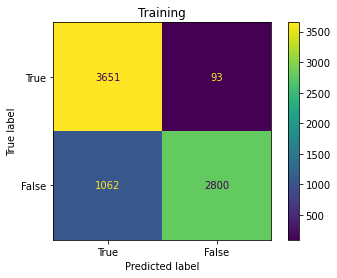

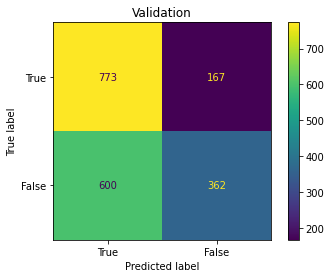

In [23]:
rf = RandomForest(Xtrain_tense, y_train)
rf.rForestClass(Xval_tense, y_val, 2)

Wow, 84 percent accuracy, and just with 2 estimators, but this was the training data, we can see the validation data was much worse at only 61% (but still better than a coin flip).

RF Accuracy on Training Data:  99.52668945569287 %
RF Accuracy on Validation Data:  69.4006309148265 %


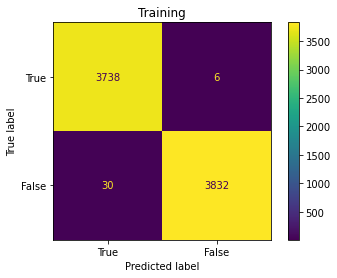

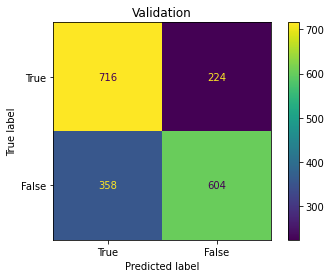

In [24]:
rf.rForestClass(Xval_tense, y_val, 20)

Now we have 99% on the training data, but the validation is still far below at 69%. 
Note: Using steming yielded the same results.

#Now lets try a Neural Net

In [58]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, SimpleRNN


Transform the torch tensor into a tensorflow tensor

In [26]:
import torch
import tensorflow as tf
nptrain_tensor = Xtrain_tense.numpy()
npval_tensor = Xval_tense.numpy()
Xtftrain_tensor = tf.convert_to_tensor(nptrain_tensor)
Xtfval_tensor = tf.convert_to_tensor(npval_tensor)
print(Xtftrain_tensor.shape)
print(Xtfval_tensor.shape)

(7606, 16569)
(1902, 16569)


I set up a Neural Net with two hidden layers, a dropout rate with flattening, and with relu activation and sigmoid final activation. For the optimizer is used adam for Stochastic Gradient Descent and Binary Cross Entropy as the loss function.

In [27]:
classifier = Sequential()
classifier.add(Dense(units=10, activation='relu', input_dim=16569))
classifier.add(Dropout(0.3))
classifier.add(Flatten())
classifier.add(Dense(units=10, activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Flatten())
classifier.add(Dense(units=10, activation='relu'))
classifier.add(Dense(units=1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

I used a batch size of 200 and 15 epochs

In [28]:
classifier.fit(Xtftrain_tensor, y_train, batch_size=200, epochs=15)
                     

Epoch 1/15
39/39 [==============================] - 2s 30ms/step - loss: 0.6931 - accuracy: 0.5076
Epoch 2/15
39/39 [==============================] - 1s 27ms/step - loss: 0.6891 - accuracy: 0.6265
Epoch 3/15
39/39 [==============================] - 1s 27ms/step - loss: 0.6635 - accuracy: 0.7330
Epoch 4/15
39/39 [==============================] - 1s 27ms/step - loss: 0.5839 - accuracy: 0.7990
Epoch 5/15
39/39 [==============================] - 1s 28ms/step - loss: 0.4544 - accuracy: 0.8717
Epoch 6/15
39/39 [==============================] - 1s 30ms/step - loss: 0.3222 - accuracy: 0.9132
Epoch 7/15
39/39 [==============================] - 1s 28ms/step - loss: 0.2248 - accuracy: 0.9365
Epoch 8/15
39/39 [==============================] - 1s 27ms/step - loss: 0.1613 - accuracy: 0.9562
Epoch 9/15
39/39 [==============================] - 1s 28ms/step - loss: 0.1157 - accuracy: 0.9717
Epoch 10/15
39/39 [==============================] - 1s 29ms/step - loss: 0.0890 - accuracy: 0.9774
Epoch 11/

In [29]:
y_pred = classifier.predict(Xtfval_tensor)
y_pred = (y_pred > 0.5)
print(y_pred)

60/60 [==============================] - 0s 4ms/step
[[ True]
 [False]
 [ True]
 ...
 [False]
 [ True]
 [ True]]


('Accuracy Score on Validation Data:', 71.55625657202944)

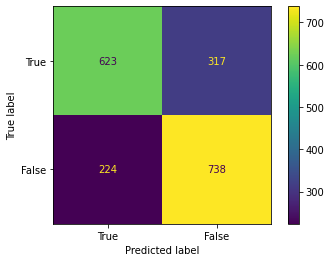

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
cm = ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred), display_labels=['True', 'False'])
cm.plot()
'Accuracy Score on Validation Data:', accuracy_score(y_val, y_pred)*100

71% on validation without bias, 70% with bias as True, 72% with dropout rate of 0.3, all with 8 epochs and batchsize of 10.
Now after changing the droupout slightly to 0.3 and 0.5 and with a batchsize of 50 and 20 epochs, I get 70% on validation.
After adding Flatten() and batchsize of 200, I get 72%
Note: Using steming yielded the same results.

In [31]:
import torchsummary
classifier.summary()
#torchsummary.summary(classifier, input_size=(165700, 110, 110))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                165700    
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 flatten_1 (Flatten)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                1

Now lets see if Lemmatization of the reviews helps validation accuracy

In [32]:
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [40]:
X_tRawLem = X_tRaw.apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
XtLemclean = X_tRawLem.apply(lambda x: ' '.join(x))
XtLemclean.head()

0                                          uma thurman medusa gorgon coiffure writhe snake stone-inducing hypnotic gaze one highlight bewitch fantasy
1                                                                        top-notch cast dazzle special effect tide teens next harry potter instalment
2    whether audiences get behind lightning thief hard predict. overall entertain introduction promise new world consume shadow potter big break free
3                                                                  really lack lightning thief genuine sense wonder thing bring viewers back hogwarts
4                                                                                              list ingredients movie-magic potion enjoy start finish
Name: tokens_raw, dtype: object

In [41]:
from sklearn.model_selection import train_test_split
X_train_lem, X_val_lem, y_train_lem, y_val_lem = train_test_split(XtLemclean, y, train_size=0.80, random_state=10)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect_lem = TfidfVectorizer()
Xtrain_hot_lem = tfidf_vect_lem.fit_transform(X_train_lem).toarray()
Xval_hot_lem = tfidf_vect_lem.transform(X_val_lem).toarray()
print(Xtrain_hot_lem.shape)
print(Xval_hot_lem.shape)

(7606, 14162)
(1902, 14162)


In [43]:
import torch
Xtrain_tense_lem = torch.tensor(Xtrain_hot_lem).float()
Xval_tense_lem = torch.tensor(Xval_hot_lem).float()
print(Xtrain_tense_lem.shape)
print(X_train_lem.shape)
print(Xval_tense_lem.shape)
print(X_val_lem.shape)

torch.Size([7606, 14162])
(7606,)
torch.Size([1902, 14162])
(1902,)


RF Accuracy on Training Data:  84.32816197738627 %
RF Accuracy on Validation Data:  56.30914826498423 %


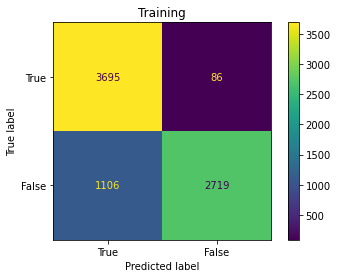

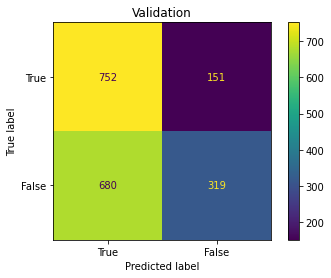

In [44]:
rf = RandomForest(Xtrain_tense_lem, y_train_lem)
rf.rForestClass(Xval_tense_lem, y_val_lem, 2)

RF Accuracy on Training Data:  99.67131212200894 %
RF Accuracy on Validation Data:  68.5068349106204 %


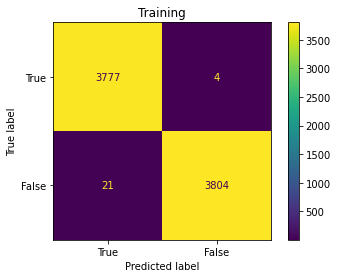

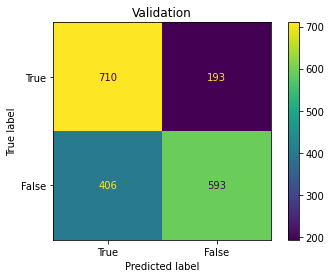

In [45]:
rf = RandomForest(Xtrain_tense_lem, y_train_lem)
rf.rForestClass(Xval_tense_lem, y_val_lem, 20)

After using the same hyperparameters with a Random Forest the accuracy was just about the same.

In [46]:
import torch
import tensorflow as tf
nptrain_tensor_lem = Xtrain_tense_lem.numpy()
npval_tensor_lem = Xval_tense_lem.numpy()
Xtftrain_tensor_lem = tf.convert_to_tensor(nptrain_tensor_lem)
Xtfval_tensor_lem = tf.convert_to_tensor(npval_tensor_lem)
print(Xtftrain_tensor_lem.shape)
print(Xtfval_tensor_lem.shape)

(7606, 14162)
(1902, 14162)


In [47]:
classifier = Sequential()
classifier.add(Dense(units=10, activation='relu', input_dim=14162))
classifier.add(Dropout(0.3))
classifier.add(Flatten())
classifier.add(Dense(units=10, activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Flatten())
classifier.add(Dense(units=10, activation='relu'))
classifier.add(Dense(units=1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
classifier.fit(Xtftrain_tensor_lem, y_train_lem, batch_size=200, epochs=15)

Epoch 1/15
39/39 [==============================] - 2s 22ms/step - loss: 0.6927 - accuracy: 0.5213
Epoch 2/15
39/39 [==============================] - 1s 21ms/step - loss: 0.6821 - accuracy: 0.6830
Epoch 3/15
39/39 [==============================] - 1s 21ms/step - loss: 0.6465 - accuracy: 0.7464
Epoch 4/15
39/39 [==============================] - 1s 20ms/step - loss: 0.5665 - accuracy: 0.8215
Epoch 5/15
39/39 [==============================] - 1s 20ms/step - loss: 0.4586 - accuracy: 0.8693
Epoch 6/15
39/39 [==============================] - 1s 21ms/step - loss: 0.3629 - accuracy: 0.9052
Epoch 7/15
39/39 [==============================] - 1s 22ms/step - loss: 0.2869 - accuracy: 0.9281
Epoch 8/15
39/39 [==============================] - 1s 21ms/step - loss: 0.2261 - accuracy: 0.9466
Epoch 9/15
39/39 [==============================] - 1s 21ms/step - loss: 0.1888 - accuracy: 0.9565
Epoch 10/15
39/39 [==============================] - 1s 20ms/step - loss: 0.1603 - accuracy: 0.9608
Epoch 11/

In [49]:
y_pred_lem = classifier.predict(Xtfval_tensor_lem)
y_pred_lem = (y_pred_lem > 0.5)
print(y_pred_lem)

60/60 [==============================] - 0s 4ms/step
[[False]
 [ True]
 [ True]
 ...
 [ True]
 [False]
 [False]]


('Accuracy Score on Validation Data:', 74.9211356466877)

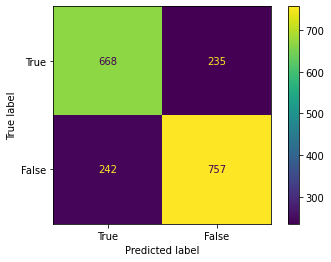

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
cm = ConfusionMatrixDisplay(confusion_matrix(y_val_lem, y_pred_lem), display_labels=['True', 'False'])
cm.plot()
'Accuracy Score on Validation Data:', accuracy_score(y_val_lem, y_pred_lem)*100

After using a Neural Net with the same parameters, we can see a fairly sizeable increase in validation accuracy, from 71 to ~75 % accuracy by using lemmatization.